# Latitude/Longitude Deltas

In [3]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
from jax.config import config

from jaxsw._src.models.qg import qg_r as qg


sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
config.update("jax_enable_x64", True)


%matplotlib inline
%load_ext autoreload
%autoreload 2

## Equations

$$

$$

$$
\begin{aligned}
\partial_t q &= - \det\boldsymbol{J}(\psi,q) - \beta\partial_x\psi \\
q &= \nabla^2 \psi - \frac{1}{L_R^2}\psi \\
\psi &= \frac{f_0}{g}\eta \\
u &= -\partial_y\psi \\
v &= \partial_x\psi \\
f &= 2\Omega\sin\theta_0 + \frac{1}{R}2\Omega\cos\theta_0 y \\
f_0 &= \mathcal{E}[f] \\
L_R &= \frac{c_1}{f_0}
\end{aligned}
$$

where:
* $f_0=2\Omega\sin\theta_0$ is the Coriolis parameter at mean latitude $\bar{\theta}$
* $\beta=\frac{1}{R}2\Omega\cos\theta_0$ is the $\beta$-plane approximation at mean latitude
* $L_R$ is the Rossby deformation radius
* $\Omega$ is the angular frequency of rotation

Source:
* [Geophysical Fluid Dynamcis - Pedlosky](https://doi.org/10.1007/978-1-4612-4650-3)
* [Atmosphere and Oceanic Fluid Dynamics - Vallis](https://doi.org/10.1017/9781107588417)

* f_0, beta are constants
* otherwise we cannot use the DST function :)

## Read input SSH

In [4]:
ds = xr.open_dataset(
    "/Users/eman/code_projects/data/scratch/NATL60_GULFSTREAM_degraded.nc"
)
ds = xr.open_dataset(
    "/Users/eman/code_projects/data/scratch/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc",
    decode_times=False,
).assign_coords(time=lambda ds: pd.to_datetime(ds.time))
# ds = ds.coarsen(lon=3,lat=3).mean()
ds

<xarray.Dataset>
Dimensions:  (time: 365, lat: 201, lon: 201)
Coordinates:
  * lon      (lon) float64 -65.0 -64.95 -64.9 -64.85 ... -55.1 -55.05 -55.0
  * lat      (lat) float64 33.0 33.05 33.1 33.15 33.2 ... 42.85 42.9 42.95 43.0
  * time     (time) datetime64[ns] 2012-10-01 2012-10-02 ... 2013-09-30
Data variables:
    ssh      (time, lat, lon) float64 ...

In [71]:
lon = ds.lon.values
lat = ds.lat.values
ssh = ds.ssh[0].values.T

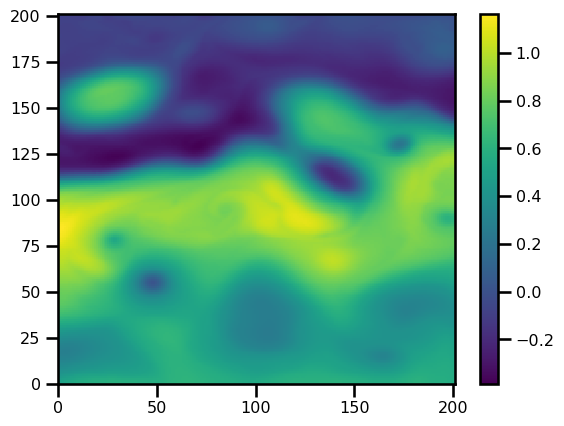

In [73]:
plt.figure()
plt.pcolormesh(ssh.T)
plt.colorbar()

In [7]:
def min_arrays(*args):
    arrays = [item for item in args]
    arrays = list(map(lambda x: x.min(), arrays))
    return np.min(np.stack([*arrays], axis=0))


def max_arrays(*args):
    arrays = [item for item in args]
    arrays = list(map(lambda x: x.max(), arrays))
    return np.max(np.stack([*arrays], axis=0))

## Naive Implementation

```python
# ssh -> pv
q = ssh_to_pv(ssh, lat, lon)
# pv -> ssh
h = pv_to_ssh(h, lat, lon)
```


$$
f_0 = 2\Omega\sin(\text{lat}\frac{\pi}{180})
$$

In [74]:
f0 = qg.coriolis_param(lat)

$$
\text{lat(m)} = 
$$

$$
d = \sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2}
$$

In [75]:
# from metpy.calc import lat_lon_grid_deltas
# out = lat_lon_grid_deltas(lon, lat)

We look at the [wiki page](https://en.wikipedia.org/wiki/Geographical_distance#Spherical_Earth_projected_to_a_plane) for the spherical Earth projected to a plane. Given some latitude, longitude pairs, $(\phi_1,\lambda_1), (\phi_2,\lambda_2)$, we can calculate the distance between them:

$$
\begin{aligned}
\Delta\phi &= \phi_2 - \phi_1 \\
\Delta\lambda &= \lambda_2 - \lambda_1
\end{aligned}
$$

We can also calculate the "mean" latitude

$$
\phi_m = \frac{\phi_1 + \phi_2}{2}
$$

Now we can calculate the distance between any set of points via the following formula:

$$
d = R \sqrt{(\Delta \phi)^2 + (cos(\phi_m)\Delta\lambda)^2}
$$

where $R$ is the radius of the Earth (6371200.0).


In [76]:
dx, dy, f = qg.lat_lon_deltas(lon, lat)

f0 = jnp.mean(f)

# Constants
# f0 = 1e-5 # Coriolis frequency
c1 = 25_000  # First baroclinic phase speed